# Assignment 8: Supervised Learning

This should be a straightforward assignment and is here just to provide a concrete example of supervised learning.

Load the titanic data set from `seaborn`. We will try to predict survival from the other variables.

In [1]:
import seaborn as sns
titanic = sns.load_dataset('titanic')

set up environment

In [2]:
seed = 2017

import numpy as np
import scipy.linalg as la
import pandas as pd
from collections import Counter

### sklearn tools
from sklearn.pipeline        import Pipeline
from sklearn.preprocessing   import StandardScaler
from sklearn.linear_model    import RidgeClassifier
from sklearn.model_selection import train_test_split, GridSearchCV

from sklearn.metrics import confusion_matrix, accuracy_score, recall_score, precision_score, f1_score
from sklearn.metrics import roc_curve, auc

### display and plot
import matplotlib.pyplot as plt
from pprint import pprint

### helper function
head = lambda x, n = 6: x[:n]
tail = lambda x, n = 6: x[-n:]

-----

**Ex 1**. (10 points)

Is the data set balanced or imbalanced? If it is badly imbalanced (say minority class under 20% of total), use down-sampling of the majority class to generate a balanced data set. Drop columns with any missing values.

In [3]:
titanic.dropna(axis = 1)["alive"].value_counts()

no     549
yes    342
Name: alive, dtype: int64

The ratio of survived people is about 38% of total, higher than 20% of total

In [4]:
342 / (549 + 342)

0.3838383838383838

The data set is not too imbalanced, so no action taken.

However, when taking a look at the data, I noticed that some columns are actually redundant in the dataset. For example, the column survived and alive are exactly the same and the column pclass is identical to the column class.

In [5]:
titanic.groupby(["survived", "alive"]).size()

survived  alive
0         no       549
1         yes      342
dtype: int64

In [6]:
titanic.groupby(["pclass", "class"]).size()

pclass  class 
1       First     216
2       Second    184
3       Third     491
dtype: int64

Also, by having the column sex and who, the information in the column adult_male is not necessary.

In [7]:
titanic.groupby(["sex", "who", "adult_male"]).size()

sex     who    adult_male
female  child  False          43
        woman  False         271
male    child  False          40
        man    True          537
dtype: int64

In [8]:
titanic.groupby(["sex", "who"]).size()

sex     who  
female  child     43
        woman    271
male    child     40
        man      537
dtype: int64

remove all the redundant columns

In [9]:
dat = titanic.dropna(axis = 1).drop(columns = ["alive", "adult_male", "pclass"])
dat.shape

(891, 8)

The result data frame

In [10]:
head(dat)

,survived,sex,sibsp,parch,fare,class,who,alone
0,0,male,1,0,7.2500,Third,man,False
1,1,female,1,0,71.2833,First,woman,False
2,1,female,0,0,7.9250,Third,woman,True
3,1,female,1,0,53.1000,First,woman,False
4,0,male,0,0,8.0500,Third,man,True
5,0,male,0,0,8.4583,Third,man,True


Note that below is the link for more description of the dataset  
[link](http://campus.lakeforest.edu/frank/FILES/MLFfiles/Bio150/Titanic/TitanicMETA.pdf)

-----

**Ex 2**. (10 points)

Convert the categorical values into dummy encoded variables , dropping the first value to avoid collinearity.

In [11]:
dat_dummy = pd.get_dummies(dat, drop_first = True)
pprint(list(dat_dummy.columns))

['survived',
 'sibsp',
 'parch',
 'fare',
 'alone',
 'sex_male',
 'class_Second',
 'class_Third',
 'who_man',
 'who_woman']


-----

**Ex 3**. (10 points)

Split the data into 70% training and 30% test data sets using stratified sampling on the sex.

In [12]:
### first specify data (X) and label (y)
X = dat_dummy.drop(columns = "survived")
y = dat_dummy["survived"]

### split training (70%) and test (30%); stratified sampling on the sex
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, stratify = X["sex_male"], random_state = seed)

check the split results

In [13]:
### frequency of geners in train
Counter(X_train["sex_male"])

Counter({0: 220, 1: 403})

In [14]:
### frequency of geners in test
Counter(X_test["sex_male"])

Counter({0: 94, 1: 174})

In [15]:
### check the size of train and test
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(623, 9)
(268, 9)
(623,)
(268,)


-----

**Ex 4**. 20 points)

Construct an `sklearn` `Pipeline` with the components `StandardScaler`, `RidgeClassifier`, and `GridSearchCV`. Train the Pipeline classifier, choosing a value for $\lambda$ from one of $\lambda = \{0, 0.1, 1, 10\}$ using grid search with 5-fold cross-validation. Note that the $\lambda$ parameter we use in the lecture is named `alpha` in `RidgeClassifier`.

In [16]:
### construct the pipeline using StandardScalar, RidgeClassifier, and GridSearchCV
pipe = Pipeline(steps=[
    ('scale',    StandardScaler()),
    ('classify', GridSearchCV(
        estimator  = RidgeClassifier(random_state = seed), 
        param_grid = {"alpha": [0, 0.1, 1, 10]},
        cv = 5))
])

### fit the pipeline and acquire the best parameters
classifier = pipe.fit(X_train, y_train)
classifier.named_steps["classify"].best_params_

{'alpha': 0}

Note that by trying different random seed, I believe the value alpha is highly depend on seed.

-----

**Ex 5**. (10 points)

Using the trained classifier, construct a confusion matrix for the test and predicted values 

More about [sklearn.metric.confusion_matrix](http://scikit-learn.org/stable/modules/generated/sklearn.metrics.confusion_matrix.html)
```
sklearn.metrics.confusion_matrix(y_true, y_pred, labels=None, sample_weight=None)
```

In [17]:
y_pred = classifier.predict(X_test)
confusion_matrix(y_test, y_pred)

array([[145,  25],
       [ 30,  68]])

-----

**Ex 6**. (10 points)

Using the confusion matrix, calculate accuracy, sensitivity, specificity, PPV, NPV and F1 score 

calculate teh metrics using the confusion matrix. In binary classification output of confution_matrix, the count of true negatives is $C_{0,0}$, false negatives is $C_{1,0}$, true positives is $C_{1,1}$ and false positives is $C_{0,1}$

http://scikit-learn.org/stable/modules/classes.html#module-sklearn.metrics

In [18]:
mat = confusion_matrix(y_test, y_pred)
TP = mat[1, 1]
FN = mat[1, 0]
FP = mat[0, 1]
TN = mat[0, 0]

accuracy    = (TP + TN) / (TP + FN + FP + TN)
sensitivity = (TP     ) / (TP + FN          )
specificity = (TN     ) / (          FP + TN)
ppv         = (TP     ) / (TP +      FP     )
npv         = (TN     ) / (     FN +      TN)

recall    = sensitivity
precision = ppv
f1 = 2 * (precision * recall) / (precision + recall)

print("Accuracy:            ", accuracy )
print("Sensitivity (Recall):", sensitivity)
print("Specificity (FPR):   ", specificity)
print("PPV:                 ", ppv)
print("NPV:                 ", npv)
print("F1:                  ", f1)

Accuracy:             0.7947761194029851
Sensitivity (Recall): 0.6938775510204082
Specificity (FPR):    0.8529411764705882
PPV:                  0.7311827956989247
NPV:                  0.8285714285714286
F1:                   0.7120418848167539


Note: I also compare my answer with the sklearn function

In [19]:
y_pred = classifier.predict(X_test)

print("Accuracy:                                 ",  accuracy_score(y_test, y_pred))
print("Sensitivity (Recall):                     ",    recall_score(y_test, y_pred))
print("Specificity (FPR):                        ")
print("Positive Predictive Value (PPV, precision)", precision_score(y_test, y_pred))
print("Negative Predictive Value (NPV)")
print("F1:                                       ",        f1_score(y_test, y_pred))

Accuracy:                                  0.7947761194029851
Sensitivity (Recall):                      0.6938775510204082
Specificity (FPR):                        
Positive Predictive Value (PPV, precision) 0.7311827956989247
Negative Predictive Value (NPV)
F1:                                        0.7120418848167539


-----

**Ex 7**.  (10 points)

Plot an ROC curve for the classifier

Some reference I found useful [(ref)](https://stackoverflow.com/questions/30051284/plotting-a-roc-curve-in-scikit-yields-only-3-points)

more about [decision_function](http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.RidgeClassifier.html#sklearn.linear_model.RidgeClassifier.decision_function)
```
Predict confidence scores for samples.
The confidence score for a sample is the signed distance of that sample to the hyperplane
```

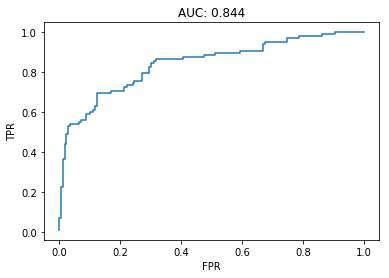

In [20]:
### get decision score and get FPR, TPR for different threshold
y_score = classifier.decision_function(X_test)
fpr, tpr, thresholds = roc_curve(y_test, y_score)

### Plot
plt.step(fpr, tpr, where='post')
plt.title('ROC curve')
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.title("AUC: " + str(np.round(auc(fpr, tpr), 3)))
pass

-----

**Ex. 8** (20 points)

- Fit polynomial curves of order 0,1,2,3,4 and 5 to the values of $X$, $y$ given below 
- Using LOOCV, what is the degree of the best-fitting polynomial model? If this is not the true degree, explain why.

generate simulated data

In [21]:
np.random.seed(23)

n = 10
k = 3
x = np.random.normal(0,1,n)
X = np.c_[np.ones(n), x, x**2, x**3]
beta = np.random.normal(0, 1, (k+1,1))
s = 0.5
y = X@beta
y += np.random.normal(0, s, y.shape)

helper functions in LOOCV

In [22]:
leave_one_out = lambda x, idx:    np.concatenate([x[:idx], x[idx + 1:]])
seq_along     = lambda x:         range(len(x))
model_matrix  = lambda x, deg:    np.array([x**i for i in range(deg + 1)]).T
polyfit       = lambda x, y, deg: la.lstsq(model_matrix(x, deg), y)

function for LOOCV

In [23]:
def loocv(x, y, max_degree = 5):
    """Perform LOOCV"""
    
    ### intialization
    rss = np.empty(max_degree + 1)
    
    ### for different model (different degree)
    for deg in range(max_degree + 1):
    
        ### residual sum of square
        rs = 0
    
        ### for each x
        for idx in seq_along(x):
        
            ### Leave one out
            x_loo = leave_one_out(x, idx)
            y_loo = leave_one_out(y, idx)
        
            ### fit the model of n-1 data
            β, residual, rank, s = polyfit(x_loo, y_loo, deg)
        
            ### predict the one left out and sum the squared residuals
            # Note: `poly1d([1, 2, 3])` = $x^2 + 2x + 3$
            # therefore the beta needs to be reversed for the poly1d function
            fit = np.poly1d(β.flatten()[::-1])
            rs += (y[idx] - fit(x[idx]))**2
    
        ### record the residual sum of squared of each model
        rss[deg] = rs
        
    return(rss)

Perform LOOCV

In [24]:
rss = loocv(x, y)
print(rss)

[ 14.47821262  10.29472876   2.71363029  40.34114869 357.48909175
 397.33845212]


the best model chosen by LOOCV is the model with degree equals to 2

In [25]:
np.argmin(rss)

2

Show the model of different degree in fitting all the data points

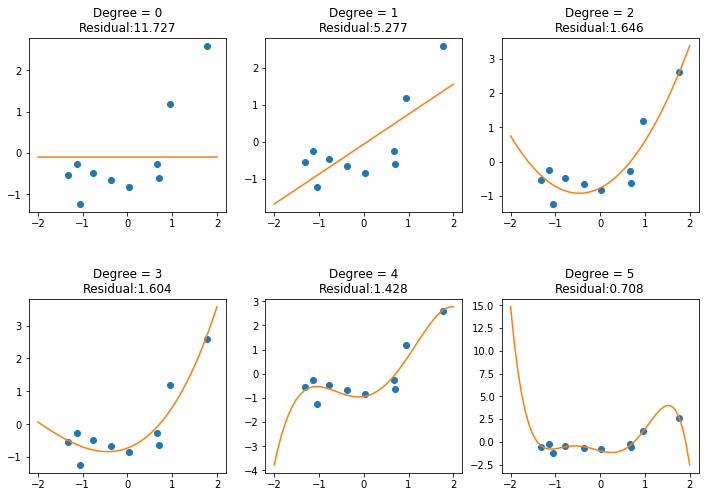

In [26]:
fig, axes = plt.subplots(2, 3, figsize = (12, 8))
plt.subplots_adjust(hspace = 0.5)
axes = axes.flatten()

x_ = np.linspace(-2, 2)

for deg in range(6):
    β, residual, rank, s = polyfit(x, y, deg)
    fit = np.poly1d(β.flatten()[::-1])
    
    ax = axes[deg]
    ax.set_title("Degree = " + str(deg) + "\nResidual:" + str(np.round(residual,3)[0]))
    
    ax.plot(x,  y, 'o')
    ax.plot(x_, fit(x_))

Why didn't the LOOCV capture the true relationship between x and y? To answer this question, below I have simulate the data points under different sample size (n) and under different effect of noise (s)

In [27]:
np.random.seed(23)

ns  = np.arange(50, 259, 50)
ss  = np.arange(0, 100, 10)
res = np.empty((len(ns), len(ss)))


for idx_n in seq_along(ns):
    for idx_s in seq_along(ss):
        
        n = ns[idx_n]
        s = ss[idx_s]
        
        k = 3
        x = np.random.normal(0,1,n)
        X = np.c_[np.ones(n), x, x**2, x**3]
        beta = np.random.normal(0, 1, (k+1,1))
        
        y = X@beta
        y += np.random.normal(0, s, y.shape)
        
        rss = loocv(x, y)
        res[idx_n, idx_s] = np.argmin(rss)

In [28]:
pd.DataFrame(res, index = ns, columns = ss)

,0,10,20,30,40,50,60,70,80,90
50,3.0,0.0,0.0,0.0,0.0,0.0,4.0,0.0,4.0,1.0
100,4.0,0.0,3.0,2.0,0.0,4.0,0.0,0.0,0.0,0.0
150,3.0,1.0,3.0,1.0,3.0,0.0,0.0,0.0,0.0,2.0
200,3.0,1.0,3.0,3.0,3.0,0.0,1.0,0.0,0.0,0.0
250,3.0,3.0,3.0,3.0,0.0,1.0,0.0,3.0,3.0,0.0


The rows are different number of data points `n` and the columns are different effect of noise `s`. The value of heatmap is the degree of model chosen by LOOCV. The results show that the three are more concentrated in the lower triangle while zero appear more often in the up-right corner. On one hand, when there is no effect of noise (s = 0), LOOCV can easily figure out the true relationship between x and y is cubic. As the effect of noise increase, since the model are trying to fit the noise, LOOCV would choose the degree zero (model with intercept only) to prevent overfitting in model with higher degree. However, LOOCV could still figure out the true relationship if the model is given more data points.

Therefore, in our case (where n = 10 and s = 0.5), the reason for LOOCV not choosing the degree as three is because the number of data points are not enough given the current effect of noise.